# Determine friction threshold velocity from a *.sno file

In [76]:
import numpy as np
import matplotlib.pyplot as plt

In [77]:
# Load file
# path = "../output/snofiles/10_10_thwaites.sno"
path = "../input/snofiles/thwaites_1.sno"
# path = "/scratch/summit/erke2265/-75.002335_0.007_VANTB.sno"

thickness, vol_frac_ice, vol_frac_air, rg, rb, sp = np.loadtxt(path, skiprows=35, usecols=[1, 3, 5, 10, 11, 13], unpack=True)
rg = rg / 1000
rb = rb / 1000
print(np.sum(thickness))
depth = np.flip(np.cumsum(np.flip(thickness)))

100.973497


In [78]:
!head -39 {path} 

SMET 1.1 ASCII
[HEADER]
station_id       = VIR1
station_name     = Virtual_Station_1
latitude         = -77.500000
longitude        = -96.250000
altitude         = 1497.1
nodata           = -999
tz               = 0
slope_angle      = 0
slope_azi        = 0
ProfileDate	 = 1980-01-01T00:30:00
HS_Last          = 100.973495
SlopeAngle       = 0.00
SlopeAzi         = 0.00
nSoilLayerData   = 0
nSnowLayerData   = 303
SoilAlbedo       = 0.09
BareSoil_z0      = 0.200
CanopyHeight     = 0.00
CanopyLeafAreaIndex = 0.000000
CanopyDirectThroughfall = 1.00
CanopySnowIntCapacity = 0.00
CanopyAlbedoDry  = 0.00
CanopyAlbedoWet  = 0.00
CanopyAlbedoSnow = 0.00
CanopyDiameter   = 0.00
CanopyFracLAIUpperLayer = 0.00
CanopyBasalArea  = 0.00
SoilEmissivity   = 0.00
WindScalingFactor = 1.00
ErosionLevel     = 302
TimeCountDeltaHS = 0.000000
fields           = timestamp Layer_Thick  T  Vol_Frac_I  Vol_Frac_W  Vol_Frac_V  Vol_Frac_S Rho_S Conduc_S HeatCapac_S  rg  rb  dd  sp  mk mass_hoar ne CDot metamo
[DATA]

In [79]:
def calc_rho(vol_frac_ice, vol_frac_air):
    rho = 917 * vol_frac_ice + 1.1 * vol_frac_air
    return rho

def calc_N3(rho, vol_frac_ice, vol_frac_air):
    
    # Retrieve density and initialize coordination number
    rho = calc_rho(vol_frac_ice, vol_frac_air)
    N3 = np.zeros(len(rho)); N3[:] = np.nan
    
    # Define constants 
    N_0 = 1.4153
    N_1 = 7.5580e-5
    N_2 = 5.1495e-5
    N_3 = 1.7345e-7
    N_4 = 1.8082e-10
    
    # Loop through each layer
    for j in range(0, len(N3)):
        R_2 = rho[j] * rho[j]
        R_3 = R_2 * rho[j]
        R_4 = R_2 * R_2
        if rho[j] >= 670:
            N3[j] = 10.5
        elif rho[j] <= 100:
            N3[j] = 1.75 * (rho[j] / 100)
        else:
            N3[j] = N_0 - N_1 * rho[j] + N_2 * R_2 - N_3 * R_3 + N_4 * R_4
    
    # Return coordination number
    return N3

# Published equations
def calc_ustar_thresh(rg, rho, vol_frac_ice, vol_frac_air, rb):
    N3 = calc_N3(rho, vol_frac_ice, vol_frac_air)
    ustar_thresh = np.sqrt((0.02 * 917 * 9.8 * rg * (sp + 1) + 0.0015 * 300 * N3 * rb**2 / rg**2) / 1.1)
    return ustar_thresh

# Modfied equations
'''
Log: 

'''
def mod_calc_ustar_thresh(rg, rho, vol_frac_ice, vol_frac_air, rb):
    N3 = calc_N3(rho, vol_frac_ice, vol_frac_air)
    ustar_thresh = np.sqrt((0.05 * 917 * 9.8 * rg * (sp + 1) + 0.0015 * 300 * N3 * rb**2 / rg**2) / 1.1)
    return ustar_thresh

def calc_10m_ws(ustar, z0):
    return ustar / 0.41 * np.log(10 / z0)



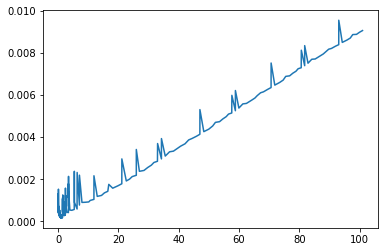

In [80]:
plt.plot(depth, rg)

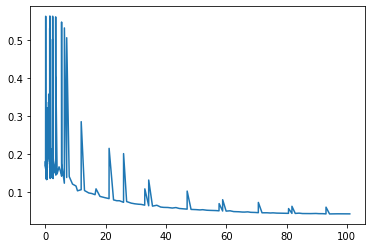

In [81]:
plt.plot(depth, rb**2 / rg**2)

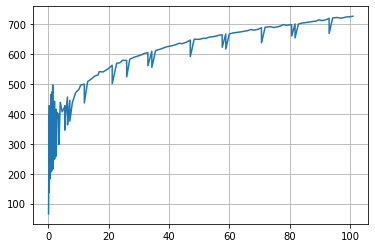

In [82]:
rho = calc_rho(vol_frac_ice, vol_frac_air)
plt.plot(depth, rho)
plt.grid()

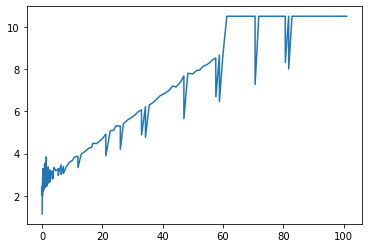

In [83]:
N3 = calc_N3(rho, vol_frac_ice, vol_frac_air)
plt.plot(depth, N3)

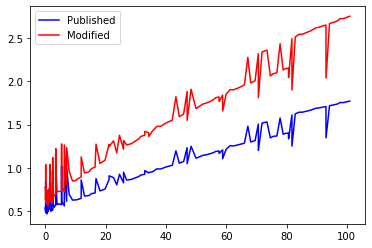

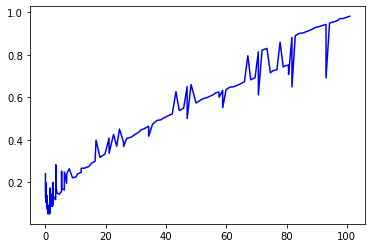

In [84]:
ustar_thresh = calc_ustar_thresh(rg, rho, vol_frac_ice, vol_frac_air, rb)
mod_ustar_thresh = mod_calc_ustar_thresh(rg, rho, vol_frac_ice, vol_frac_air, rb)

plt.figure()
plt.plot(depth, ustar_thresh, 'b', label="Published")
plt.plot(depth, mod_ustar_thresh, 'r', label="Modified")
plt.legend()

plt.figure()
plt.plot(depth, mod_ustar_thresh - ustar_thresh, 'b', label="Modified minus published")

10.855527722043279


Text(0, 0.5, 'Total Thickness Layers [m]')

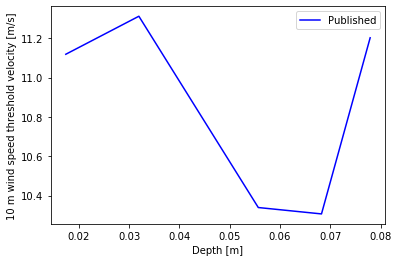

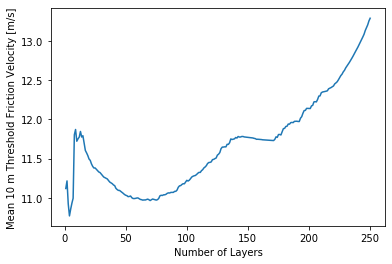

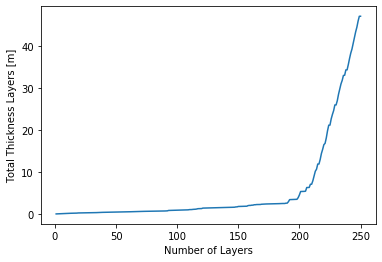

In [85]:
ws10m = calc_10m_ws(ustar_thresh, 0.002)
mod_ws10m = calc_10m_ws(mod_ustar_thresh, 0.002)

plt.figure()
n = 5
plt.plot(depth[-n:], ws10m[-n:], 'b', label="Published")
# plt.plot(depth, mod_ws10m, 'r', label="Modified")
plt.legend()
plt.xlabel("Depth [m]")
plt.ylabel("10 m wind speed threshold velocity [m/s]")
# plt.xlim([0, 3])
print(ws10m[-n:].mean())

# plt.figure()
# plt.plot(depth, mod_ws10m - ws10m, 'b', label="Modified minus published")

# Make a plot of the number of layers vs mean threshold velocity
n_layers = 250
layers = np.arange(1, n_layers + 1)
layer_mean = np.zeros(n_layers)
total_depth = np.zeros(n_layers)
for j in range(1, n_layers + 1):
    layer_mean[j-1] = ws10m[-j:].mean()
    total_depth[j-1] = depth[-j]

plt.figure()
plt.plot(layers, layer_mean)
plt.xlabel("Number of Layers")
plt.ylabel("Mean 10 m Threshold Friction Velocity [m/s]")

plt.figure()
plt.plot(layers, total_depth)
plt.xlabel("Number of Layers")
plt.ylabel("Total Thickness Layers [m]")


# Compare the average threshold velocity of the top layer to the top 5 layers.

In [86]:
import os
N = 10
src_directory = "../output/snofiles/"
N_files = len(os.listdir(src_directory))
one_layer_mean = np.zeros(N_files); one_layer_mean[:] = np.nan
N_layer_mean = np.zeros(N_files); N_layer_mean[:] = np.nan

for count, filename in enumerate(os.listdir(src_directory)):
    if count % 10 == 0:
        thickness, vol_frac_ice, vol_frac_air, rg, rb, sp = np.loadtxt(path, skiprows=35, usecols=[1, 3, 5, 10, 11, 13], unpack=True)
        rg = rg / 1000
        rb = rb / 1000
        depth = np.flip(np.cumsum(np.flip(thickness)))
        ustar_thresh = calc_ustar_thresh(rg, rho, vol_frac_ice, vol_frac_air, rb)
        ws10m = calc_10m_ws(ustar_thresh, 0.002)
        one_layer_mean[count] = ws10m[-1:]
        N_layer_mean[count] = ws10m[-N:].mean()
    else:
        Lol=2
        
#     print("    First Layer Ustar Thresh = " + str(ws10m[-1:]))
#     print("    First N Layers Ustar Thresh = " + str(ws10m[-N:].mean()))

nan


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


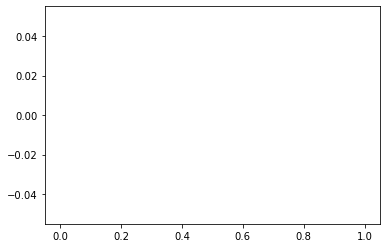

In [87]:
plt.hist(one_layer_mean)
print(np.nanmean(one_layer_mean))

nan


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


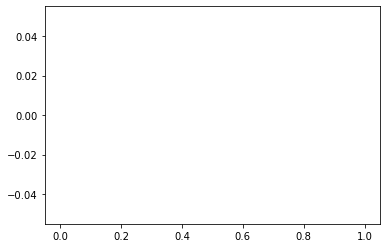

In [88]:
plt.hist(N_layer_mean)
print(np.nanmean(N_layer_mean))